# Deep Neural Network for Image Classification: Application


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage import transform

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

np.random.seed(1)

In [2]:
np.set_printoptions(threshold=16, suppress=True, precision=5)

In [3]:
test = h5py.File('./datasets/test_catvnoncat.h5', 'r')
test.keys()

<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>

In [52]:
def load_data():
    test_data = h5py.File('./datasets/test_catvnoncat.h5', 'r')
    test_set_x =  np.array(test_data['test_set_x'][:])
    test_set_y =  np.array(test_data['test_set_y'][:])

    train_data = h5py.File('./datasets/train_catvnoncat.h5', 'r')
    train_set_x =  np.array(train_data['train_set_x'][:])
    train_set_y =  np.array(train_data['train_set_y'][:])

    labels = np.array(train_data['list_classes'][:])
    
    return train_set_x, train_set_y, test_set_x, test_set_y, labels

In [53]:
train_set_x, train_set_y, test_set_x, test_set_y, labels = load_data()

In [54]:
m = train_set_x.shape[0]
X_train, y_train = train_set_x.reshape((m, -1)) / 255., train_set_y
m = test_set_x.shape[0]
X_test, y_test = test_set_x.reshape((m, -1)) / 255., test_set_y

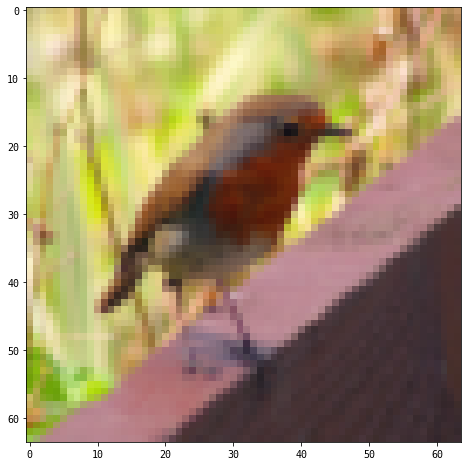

In [55]:
# Example of a picture
index = 10
plt.imshow(train_set_x[index])

In [8]:
labels = list(map(bytes.decode, labels.ravel()))
labels

['non-cat', 'cat']

In [56]:
print('train x: ', X_train.shape)
print('train y: ', y_train.shape)

print('test x: ', X_test.shape)
print('test y: ', y_test.shape)

train x:  (209, 12288)
train y:  (209,)
test x:  (50, 12288)
test y:  (50,)


In [57]:
class Layer:
    def __init__(self, n_input_dims, n_neurons, activation=None, weights=None, bias=None):
        self.weights = weights if weights is not None else np.random.randn(
            n_input_dims, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.randn(n_neurons) * 0.1
        self.activation = activation
        self.A = None
        self.dA = None
        self.dZ = None

    def activate(self, X):
        Z = np.dot(X, self.weights) + self.bias
        # 激活函数的输出
        self.A = self._apply_activation(Z)
        return self.A
    
    def _apply_activation(self, Z):
        # 激活函数
        if self.activation is None:
            return Z
        elif self.activation == 'relu':
            return np.maximum(0, Z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif self.activation == 'tanh':
            return np.tanh(Z)
        else:
            return Z
    
    def derivative(self, A):
        # 激活函数的导数
        if self.activation is None:
            return np.ones_like(A)
        elif self.activation == 'relu':
            # return np.where(A <= 0, 0., 1.)
            d = np.array(A, copy=True)
            d[A <= 0] = 0.
            d[A > 0] = 1.
            return d 
        elif self.activation == 'sigmoid':
            return A  * (1 - A)
        elif self.activation == 'tanh':
            return 1 - A ** 2
        else:
            return A
    
    def __repr__(self):
        return f"weigths: {self.weights.shape}\n bias: {self.bias.shape}"

In [94]:
class DeepNeuralNetwork:
    def __init__(self):
        self.layers = []
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def feed_forward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X

    def loss(self, y_true, y_preds):
        # 交叉熵误差
        assert(y_true.shape == y_preds.shape)
        loss_ = - y_true* np.log(y_preds) - (1 - y_true)*np.log(1 - y_preds)  

        return np.squeeze(np.mean(loss_, axis=0))
    
    def backpropagation(self, X, y, learning_rate):
        # 反向传播算法 计算每一层的delta 
        # 前向计算 得到输出值
        m = X.shape[0]  # batch size
        out = self.feed_forward(X)  # (m, 1)
        # print(out.shape)
        # loss_ = self.loss(y, out)

        for i in reversed(range(len(self.layers))):  # 从最后一层开始
            layer = self.layers[i]
            if layer == self.layers[-1]:  # 输出层
                # 使用 交叉熵 误差
                assert(y.shape == out.shape)
                layer.dA = -y/out + (1-y) / (1-out)
                # layer.dA = -y / out + (1-y)/(1-out)  # dL/dA^K  # (m, 1)
                layer.dZ = 1/ m * layer.dA * layer.derivative(out) # dL/dZ^K  (m, 1) (m, 1)
            else:  # 隐藏层
                next_layer = self.layers[i + 1]
                layer.dA = next_layer.dZ @ next_layer.weights.T  # dL/dA^J (m, 1) (1, k)
                # dL/dZ^J (m, k) (m,k)
                layer.dZ = 1/ m * layer.dA * layer.derivative(layer.A)
        
        # 更新参数
        for i in range(len(self.layers)):
            layer = self.layers[i]
            # 上一层的输出 本层的输入
            o_i = X if i == 0 else self.layers[i-1].A
            # weights (I, J)
            # o_i (m, I)
            # dZ (m, J)
            layer.weights -= learning_rate *  o_i.T @ layer.dZ  # (I, J)
            layer.bias -=  learning_rate * np.mean(layer.dZ)  # (J, )

    def fit(self, X, y, learning_rate=0.01 ,max_epochs=300):
        y = y.reshape(-1, 1)
        cross_entropy = []
        batch_size = 16
        split_size = X.shape[0] // batch_size
        
        for epoch in range(max_epochs):
            for x, y_true in zip(np.array_split(X, split_size), np.array_split(y, split_size)):
                self.backpropagation(x, y_true, learning_rate)
            # self.backpropagation(X, y, learning_rate)
            if epoch % 10 == 0:
                # mse = np.mean(np.square(self.feed_forward(X) - y_onehot))
                loss = self.loss(y, self.feed_forward(X))
                cross_entropy.append(loss)
                print(f'Epoch: {epoch}, cross_entropy: {loss}')
        return cross_entropy
    
    def predict(self, X):
        y_pred = self.feed_forward(X)
        y_pred = np.where(y_pred >0.5, 1, 0)
        # out = np.argmax(y_pred, axis=1)
        return np.squeeze(y_pred)

In [97]:
model = DeepNeuralNetwork()
model.add_layer(Layer(X_train.shape[1], 20, 'tanh'))  # h1  
model.add_layer(Layer(20, 7, 'tanh'))  # output
model.add_layer(Layer(7, 5, 'tanh'))  # output
model.add_layer(Layer(5, 1, 'sigmoid'))  # output
cross_entropy = model.fit(X_train, y_train, learning_rate=0.0001, max_epochs=1000)

Epoch: 0, cross_entropy: 1.0708294594704708
Epoch: 10, cross_entropy: 1.0683648778724435
Epoch: 20, cross_entropy: 1.0659139074200914
Epoch: 30, cross_entropy: 1.063476501068253
Epoch: 40, cross_entropy: 1.0610526115516112
Epoch: 50, cross_entropy: 1.0586421913899522
Epoch: 60, cross_entropy: 1.056245192893416
Epoch: 70, cross_entropy: 1.0538615681677213
Epoch: 80, cross_entropy: 1.0514912691193845
Epoch: 90, cross_entropy: 1.0491342474609175
Epoch: 100, cross_entropy: 1.0467904547160085
Epoch: 110, cross_entropy: 1.0444598422246825
Epoch: 120, cross_entropy: 1.0421423611484444
Epoch: 130, cross_entropy: 1.039837962475398
Epoch: 140, cross_entropy: 1.037546597025343
Epoch: 150, cross_entropy: 1.0352682154548556
Epoch: 160, cross_entropy: 1.033002768262336
Epoch: 170, cross_entropy: 1.0307502057930387
Epoch: 180, cross_entropy: 1.028510478244068
Epoch: 190, cross_entropy: 1.0262835356693623
Epoch: 200, cross_entropy: 1.0240693279846333
Epoch: 210, cross_entropy: 1.0218678049722911
Epoch

KeyboardInterrupt: 

In [72]:
y_pred = model.predict(X_test)
y_pred.shape

(50,)

In [73]:
np.sum(np.squeeze(y_pred) == y_test)

32